In [3]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb

In [4]:
train_final = pd.read_csv('train_final.csv')
y = train_final.Credit_Rating
X = train_final.drop(columns = 'Credit_Rating')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

X = X_train[X_train.columns]
y = y_train

In [5]:
#K-fold cross validation to find optimal parameters for XGBoost
start_time = time.time()
param_grid = {'max_depth': [4,6,8],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 1, 10],
                'n_estimators':[100, 500, 1000],
                'gamma': [0, 10, 100],
                'subsample': [0.5, 0.75, 1.0],
                'colsample_bytree': [0.5, 0.75, 1.0]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Optimal parameter values = {'subsample': 0.5, 'reg_lambda': 1, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 100, 'colsample_bytree': 0.5}
Optimal cross validation R-squared =  0.3043007736728983
Time taken =  209  minutes


In [8]:
means = optimal_params.cv_results_['mean_test_score']
stds = optimal_params.cv_results_['std_test_score']
params = optimal_params.cv_results_['params']

In [10]:
np.sqrt(mean_squared_error(optimal_params.best_estimator_.predict(X_test),y_test))

62.607929378990775

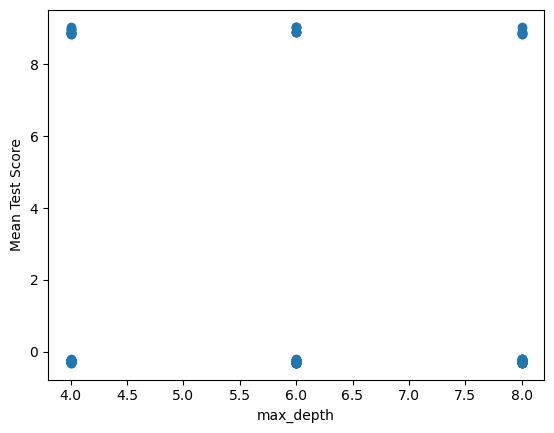

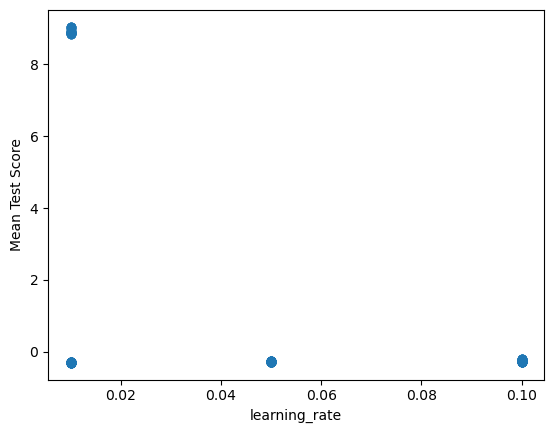

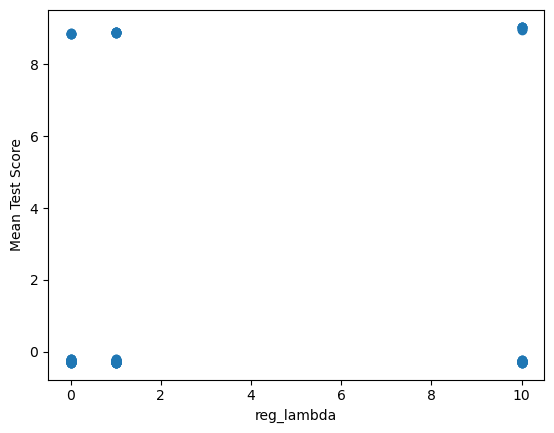

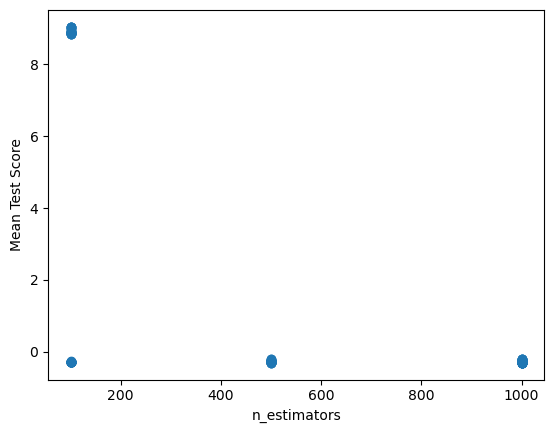

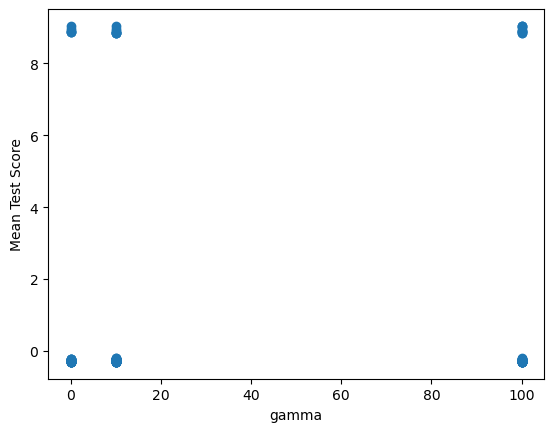

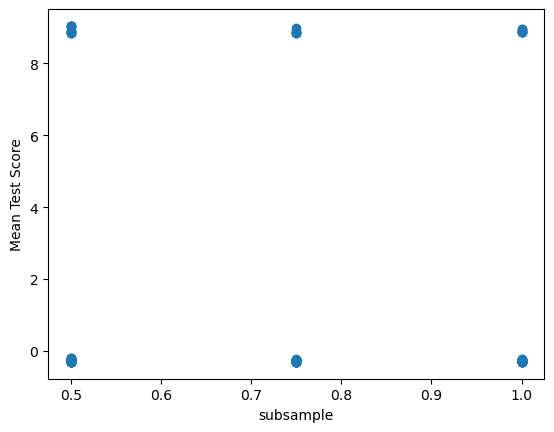

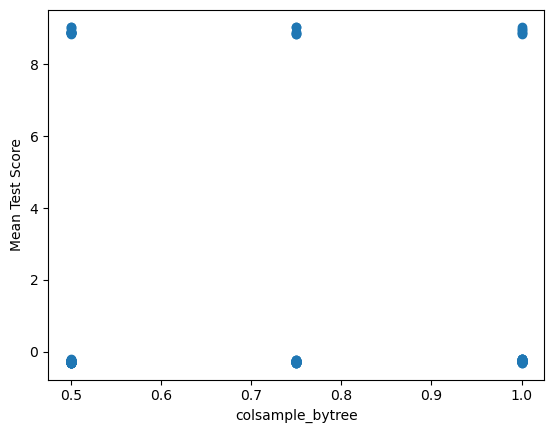

In [12]:
param_names = ['max_depth','learning_rate','reg_lambda','n_estimators','gamma','subsample','colsample_bytree']

for i in range(len(param_names)):
    values = []
    for j in range(len(params)):
        values.append(params[j][param_names[i]])    
    fig, ax = plt.subplots()
    ax.scatter(values, -means)
    ax.set_xlabel(param_names[i])
    ax.set_ylabel('Mean Test Score')    
    plt.show()

### Tuning Round 2

In [13]:
start_time = time.time()
param_grid = {'max_depth': [5,6,7],
              'learning_rate': [0.01,0.011],
               'reg_lambda':[0.4,1,1.5],
                'n_estimators':[1000, 2000, 3000],
                'gamma': [50,100],
                'subsample': [0.45,0.5,0.55],
                'colsample_bytree': [0.4,0.5]}

cv = KFold(n_splits=2,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1,n_jobs=-1,cv=cv)
optimal_params.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 2 folds for each of 200 candidates, totalling 400 fits
Optimal parameter values = {'subsample': 0.55, 'reg_lambda': 1, 'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 50, 'colsample_bytree': 0.4}
Optimal cross validation R-squared =  0.29808763910949904
Time taken =  108  minutes


In [14]:
np.sqrt(mean_squared_error(optimal_params.best_estimator_.predict(X_test),y_test))

62.4402538696938

### Tuning Round 3

In [ ]:
start_time = time.time()
param_grid = {'max_depth': [7],
              'learning_rate': [0.01,0.0088],
               'reg_lambda':[0.4],
                'n_estimators':[1000,1500,1650],
                'gamma': [15,50],
                'subsample': [0.5,0.55],
                'colsample_bytree': [0.4]}

cv = KFold(n_splits=2,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1,n_jobs=-1,cv=cv)
optimal_params.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

In [ ]:
## hopefully this gives the params below bc it gives the lowest rmse out of everything i've tried 

In [81]:
model = xgb.XGBRegressor(random_state=1,
                         subsample=0.5,
                         reg_lambda=0.4,
                         n_estimators=1650,
                         max_depth=7,
                         learning_rate=0.0088,
                         gamma=15,
                         colsample_bytree=0.4).fit(X_train,y_train)

In [82]:
np.sqrt(mean_squared_error(model.predict(X_test),y_test))

61.99042016249118

#### Change n_estimators

In [15]:
model = xgb.XGBRegressor(random_state=1,
                         subsample=0.55,
                         reg_lambda=0.4,
                         n_estimators=1500,
                         max_depth=7,
                         learning_rate=0.01,
                         gamma=50,
                         colsample_bytree=0.4).fit(X_train,y_train)

In [16]:
np.sqrt(mean_squared_error(model.predict(X_test),y_test))

62.4139896427408

#### Change gamma

In [19]:
model = xgb.XGBRegressor(random_state=1,
                         subsample=0.55,
                         reg_lambda=0.4,
                         n_estimators=1700,
                         max_depth=7,
                         learning_rate=0.01,
                         gamma=50,
                         colsample_bytree=0.4).fit(X_train,y_train)

In [20]:
np.sqrt(mean_squared_error(model.predict(X_test),y_test))

62.409190087015496

In [21]:
model = xgb.XGBRegressor(random_state=1,
                         subsample=0.55,
                         reg_lambda=0.4,
                         n_estimators=1700,
                         max_depth=7,
                         learning_rate=0.01,
                         gamma=10,
                         colsample_bytree=0.4).fit(X_train,y_train)

In [22]:
np.sqrt(mean_squared_error(model.predict(X_test),y_test))

62.18033427183459

In [25]:
model = xgb.XGBRegressor(random_state=1,
                         subsample=0.55,
                         reg_lambda=0.4,
                         n_estimators=1700,
                         max_depth=7,
                         learning_rate=0.01,
                         gamma=15,
                         colsample_bytree=0.4).fit(X_train,y_train)

In [26]:
np.sqrt(mean_squared_error(model.predict(X_test),y_test))

62.16874941002506

#### Change subsample

In [43]:
model = xgb.XGBRegressor(random_state=1,
                         subsample=0.5,
                         reg_lambda=0.4,
                         n_estimators=1700,
                         max_depth=7,
                         learning_rate=0.01,
                         gamma=15,
                         colsample_bytree=0.4).fit(X_train,y_train)

In [44]:
np.sqrt(mean_squared_error(model.predict(X_test),y_test))

62.042784400419926

#### Change learning_rate

In [59]:
model = xgb.XGBRegressor(random_state=1,
                         subsample=0.5,
                         reg_lambda=0.4,
                         n_estimators=1700,
                         max_depth=7,
                         learning_rate=0.0088,
                         gamma=15,
                         colsample_bytree=0.4).fit(X_train,y_train)

In [60]:
np.sqrt(mean_squared_error(model.predict(X_test),y_test))

62.012905366645825